# calculating extreme heat from cal-adapt and pyextremes

In [7]:
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools

import pyextremes
from pyextremes import EVA

import matplotlib.pyplot as plt
%matplotlib inline

## step 1, request data

In [2]:
# cal-adapt API
api = 'http://api.cal-adapt.org/api'

# request header
headers = {'ContentType': 'json'}

# geo params (lon lat)
# point is berkeley, california
point = 'POINT(-122.270506 37.869521)'
params = {'g': point}

In [3]:
# climate variable
climvar = 'tasmax'

# climate models
models = ['CNRM-CM5', 'HadGEM2-ES']

# climate scenarios
scenarios = ['rcp85']

### get historical data

In [4]:
# request and process historical daily timeseries from cal-adapt api

def process_daily_data(slug, params):
    
    # make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params, headers=headers)
    
    # get data
    if response.ok:
        print('processing:', slug)
        json = response.json()
        data = json['results'][0]

        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # get total number of values -> number of days
        length = len(values_arr)

        # get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')
        
        # create a new dataframe, map each value in values_arr  to a date index
        # and add it as a new row to the dataframe
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )
            
        # add series name and scenario from the slug as columns
        series_name = slug.split('_')[2]
        scenario = ''
        if (series_name == 'livneh'):
            scenario = 'historical'
        else:
            scenario = slug.split('_')[3]
        df['series'] = series_name
        df['scenario'] = scenario

    else:
        print('failed to download:', slug)
            
    # combine all the dataframes into one and return
    return df

In [ ]:
# download historical observed daily timeseries from cal-adapt api

def get_daily_observed(climvar):
    slug = climvar + '_day_livneh'
    df = process_daily_data(slug, params)
    return df

In [8]:
# get historical daily time series

hist_df = get_daily_observed(climvar)
hist_df.head()

processing: tasmax_day_livneh


,value,series,scenario
1950-01-01,11.46,livneh,historical
1950-01-02,10.83,livneh,historical
1950-01-03,8.30,livneh,historical
1950-01-04,6.19,livneh,historical
1950-01-05,9.70,livneh,historical


### get projected data

In [9]:
# download model projections from cal-adapt api

def get_daily_projections(climvar, models, scenarios):
    
    # create an empty list to hold dataframes
    df_list = []

    # make a combined list of GCMs, scenarios, climate variables for looping
    zipped = itertools.product([climvar], ['day'], models, scenarios)
    
    # request parameters
    params = {'g': point}

    # loop through zipped
    for item in zipped:
        # create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # combine all the dataframes into one and return
    return pd.concat(df_list)

In [10]:
# get projected daily time series

proj_df = get_daily_projections(climvar, models, scenarios)
proj_df.head()

processing: tasmax_day_CNRM-CM5_rcp85
processing: tasmax_day_HadGEM2-ES_rcp85


,value,series,scenario
2006-01-01,288.702759,CNRM-CM5,rcp85
2006-01-02,289.224731,CNRM-CM5,rcp85
2006-01-03,288.675598,CNRM-CM5,rcp85
2006-01-04,286.545746,CNRM-CM5,rcp85
2006-01-05,286.934021,CNRM-CM5,rcp85


In [11]:
# convert kelvin to celsius

proj_df['value'] = proj_df['value'].subtract(273.15)
proj_df.head()

,value,series,scenario
2006-01-01,15.552759,CNRM-CM5,rcp85
2006-01-02,16.074731,CNRM-CM5,rcp85
2006-01-03,15.525598,CNRM-CM5,rcp85
2006-01-04,13.395746,CNRM-CM5,rcp85
2006-01-05,13.784021,CNRM-CM5,rcp85


### combine historical and projected dataframes

In [12]:
# divide out by model

proj_df_cnrm = proj_df.query("series == 'CNRM-CM5'")
proj_df_hadgem2 = proj_df.query("series == 'HadGEM2-ES'")

In [13]:
# only take 2014 onwards to merge later with historical model

proj_df_cnrm_2014_onwards = proj_df_cnrm.loc[(proj_df_cnrm.index >= '2014-01-01')]
proj_df_hadgem2_2014_onwards = proj_df_hadgem2.loc[(proj_df_hadgem2.index >= '2014-01-01')]

<AxesSubplot:>

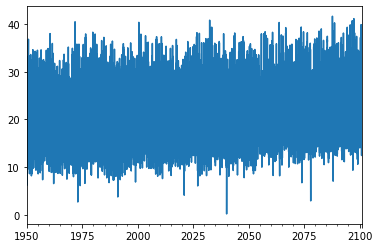

In [14]:
# combine historical and projected into one dataframe

combined_df_cnrm = pd.concat([hist_df, proj_df_cnrm_2014_onwards], ignore_index=False, sort=True)
combined_df_cnrm['value'].plot()

<AxesSubplot:>

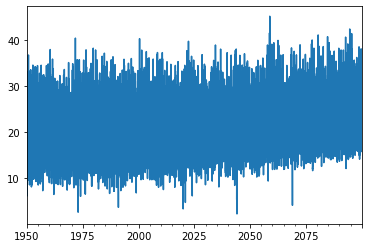

In [15]:
combined_df_hadgem2 = pd.concat([hist_df, proj_df_hadgem2_2014_onwards], ignore_index=False, sort=True)
combined_df_hadgem2['value'].plot()

## step 2, calculate extremes using pyextremes

In [16]:
# create series from dataframe

cnrm_series = pd.DataFrame(combined_df_cnrm, columns = ['value'])
cnrm_series = cnrm_series.squeeze()

hadgem2_series = pd.DataFrame(combined_df_hadgem2, columns = ['value'])
hadgem2_series = hadgem2_series.squeeze()

### run model for historical + cnrm-cm5 model

In [37]:
model = EVA(cnrm_series)

In [38]:
model.get_extremes(method="BM", block_size="365.2425D")

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='date-time', ylabel='value'>)

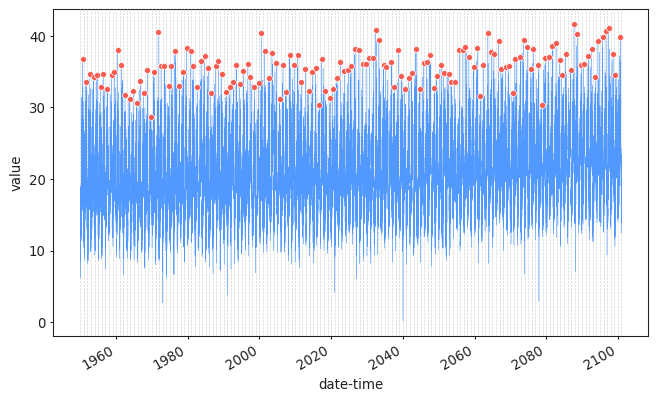

In [39]:
model.plot_extremes()

In [40]:
model.fit_model()

In [41]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)

/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [42]:
print(summary)

               return value   lower ci   upper ci
return period                                    
1.0                    -inf        NaN        NaN
2.0               35.642909  35.183819  36.097380
5.0               37.826706  37.344875  38.285784
10.0              38.917429  38.412445  39.376233
25.0              39.990138  39.394446  40.475512
50.0              40.612217  39.936937  41.177020
100.0             41.113855  40.347653  41.781592
250.0             41.634222  40.739946  42.508253
500.0             41.943155  40.974432  43.010075
1000.0            42.194467  41.157503  43.426634


### run model for historical + hadgem2-es model

In [43]:
model = EVA(hadgem2_series)

In [44]:
model.get_extremes(method="BM", block_size="365.2425D")

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='date-time', ylabel='value'>)

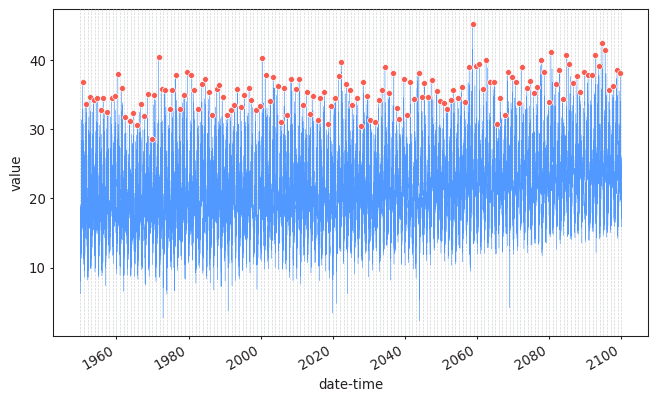

In [45]:
model.plot_extremes()

In [46]:
model.fit_model()

In [47]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)

/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/nabig/opt/anaconda3/envs/intro_climate_data/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [49]:
print(summary)

               return value   lower ci   upper ci
return period                                    
1.0                    -inf        NaN        NaN
2.0               35.424510  34.995099  35.942419
5.0               37.910455  37.319508  38.509928
10.0              39.309601  38.482383  39.994445
25.0              40.838425  39.579313  41.761745
50.0              41.822332  40.235521  42.992847
100.0             42.688359  40.673984  44.232471
250.0             43.681374  41.199832  45.513647
500.0             44.334002  41.491093  46.517219
1000.0            44.912984  41.719151  47.509784
